<h1 align=center><font color="Black" >Sentiment Analysis for Financial News  </font>

**Import all the required libraries**

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,Embedding, Flatten, Input,LSTM
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

## Table of Content

<font size=3.5>
   
* [Introduction](#introduction)
* [Methodology, Result and Discussion](#Methodology)
* [Limitation](#lim)
* [Conclusion](#conclusion)
* [Reference](#ref)   
    </font>

# **Introduction** <a id='introduction'></a>

This is the capstone project for the specialization "Advanced Data Science with IBM" on Coursera. 

**Data**

This project utilizes the open source data from Kraggle.

https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news


This dataset contains the sentiments for financial news headlines from the perspective of a retail investor. The dataset contains two columns, "Sentiment" and "News Headline". The sentiment can be negative, neutral or positive.

**Use Case**

The data is used to train a sentiment classifying model. The model can then be utilized to detect polarity (e.g. a positive or negative opinion) within text, for a lot of applications such as brand monitoring, social media monitoring, market research etc. 

# **Methodology, Result and Discussion** <a id='Methodology'></a>

* [ETL, Pre-processing and Data Understanding](#pre)
* [Feature Engineering ](#fe)
* [Model Definition, Training and Evaluation ](#mo)
* [Model Testing](#tes)


## ETL, Pre-processing and Data Understanding<a id='pre'></a>

The data is read into a pandas data frame.

In [2]:
data='https://github.com/boonway147/Advanced-Data-Science_IBM_Coursera/blob/main/Sentiment%20Analysis%20for%20Financial%20News.xlsx?raw=true'
df=pd.read_excel(data,header=None)
df

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


Rename the columns

In [3]:
# Rename the column

df.columns=['Sentiment',"News"]
df.head()

,Sentiment,News
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [25]:
#check the size of the data

df.shape

(4846, 2)

In [26]:
#Check for missing data

missing_data=df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")


Sentiment
False    4846
Name: Sentiment, dtype: int64

News
False    4846
Name: News, dtype: int64



There is no missing data. Now, we check for duplicate data

In [27]:
df.duplicated().sum()

6

In [28]:
# remove the duplicate 

df.drop_duplicates(inplace=True)
df.shape

(4840, 2)

After removing the duplicated rows, 4840 rows remains. 

The distribution of data is evaluated

In [29]:
# checking the distribution of data

df['Sentiment'].value_counts()

neutral     2873
positive    1363
negative     604
Name: Sentiment, dtype: int64

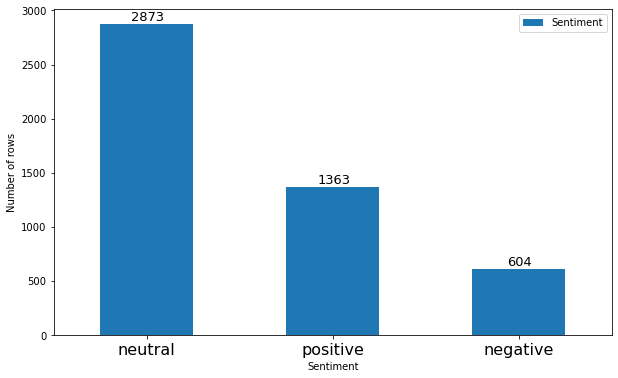

In [30]:
# visualize the distribution of data

ax=df['Sentiment'].value_counts().to_frame().plot(kind='bar',figsize=(10,6))
ax.set_ylabel('Number of rows')
ax.set_xlabel("Sentiment")
ax.tick_params(axis='x', labelsize=16,rotation=0)

def add_value_labels(ax, spacing=5):
    
        for rect in ax.patches:
            y_value = round(rect.get_height(),0)
            x_value = rect.get_x() + rect.get_width() / 2
        
             
            label = (y_value)

            ax.annotate(
            label,                      
            (x_value, y_value),         
            textcoords="offset points", 
            xytext=(1,1),
            ha='center',                
            va='bottom',fontsize=13)                     
                                        


add_value_labels(ax)

As shown above, there are far more neutral sentiment data than positive and negative sentiment data.

**Visualization of text data by Word Cloud.**

The frequent words in the data are visualized.

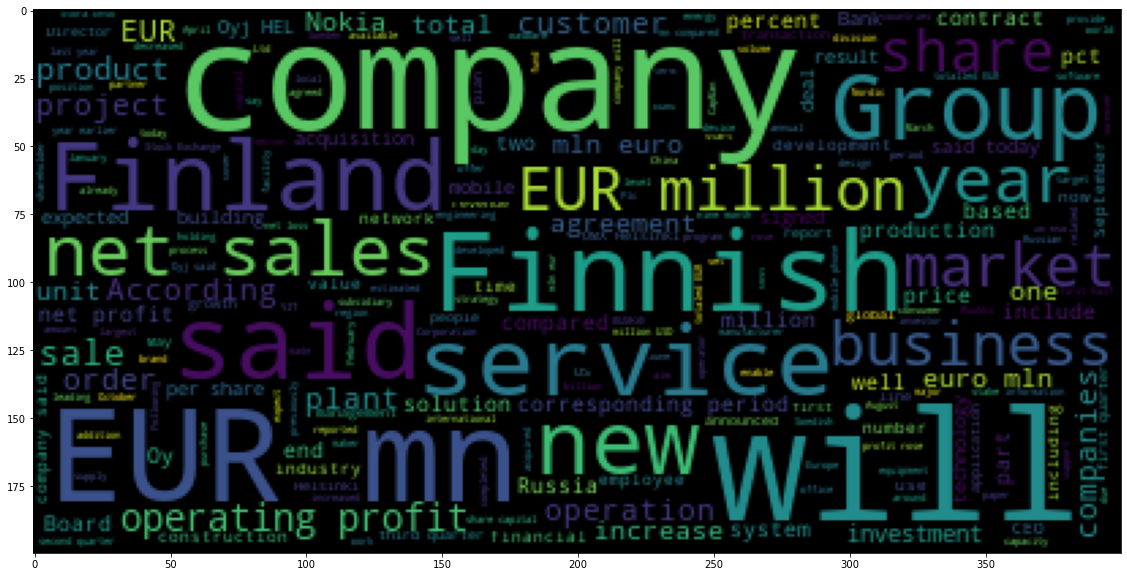

In [31]:
# remove any redundant stopwords.
stopw = set(STOPWORDS)

# instantiate a word cloud object
plt.figure(figsize=(20,10))
wc= WordCloud(
    background_color='black',
    max_words=40000,
    stopwords=stopw
).generate(" ".join(df['News']))

plt.imshow(wc)


## Feature Engineering  <a id='fe'></a>

The sentiment is converted to numerical label.

In [32]:
# Convert the sentiment from text
sentiment  = {'positive': 2,'neutral': 1,'negative':0}

df.Sentiment=[sentiment [x] for x in df.Sentiment]
df.head()

,Sentiment,News
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


The text data in the column "News" are vectorized.

In [33]:
# vectorize the text
tokenizer1 = Tokenizer(num_words=20000)
tokenizer1.fit_on_texts(df['News'])
sequences = tokenizer1.texts_to_sequences(df['News'])

word_index = tokenizer1.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10122 unique tokens.


In [49]:
# check the maximum sentence length
sentence_length=[]
for i in range (len(sequences)):
    leng=len(sequences[i])
    sentence_length.append(leng)
    
max_sentence_length=max(sentence_length)
print (max_sentence_length)

71


In [35]:
#pad the data
data = pad_sequences(sequences, maxlen=70)

**Splitting of data to training and testing set.**

In [36]:
x_train, x_test, y_train, y_test = train_test_split(data, df['Sentiment'], test_size = 0.2, random_state = 0)

In [37]:
#take a look on the x_train
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          1,   12,  251,   30,   27,    2, 7381,    3,  111,    4,  165,
        130,   38,  436,  167])

In [39]:
#check the shape of x_train and x_test 
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(3872, 70)
(968, 70)
(3872,)
(968,)


## Model Definition, Training and Evaluation<a id='mo'></a>

Traditional machine learning algorithms and deep learning neural network models are built. Their performances are compared.

* [Traditional machine learning algorithm](#td)
* [Neural network ](#nn)

### Traditional Machine Learning Algorithm <a id='td'></a>

4 types of traditional machine learning algorithms are used,  namely:

[SVM](#svm)

[K Neighbours](#knn)

[Logistic Regression](#lr)

[Multinomial Naive Bayes](#mnb)

**SVM** <a id='svm'></a>

The performance of the SVM model based on different types of kernel are compared.

In [249]:
kernel=['rbf','poly','rbf','sigmoid']
SVM_Acc=np.zeros((4))
for n in range(4):
    svm1=svm.SVC(kernel=kernel[n])
    svm1.fit(x_train,y_train)
    svm1_result=svm1.predict(x_test)
    SVM_Acc[n]=metrics.accuracy_score(y_test,svm1_result)

SVM_Acc

array([0.59297521, 0.55681818, 0.59297521, 0.5072314 ])

It's shown above that model trained with kernel'rbf' gives us the best result. The model is retrained with kernel 'rbf' to record its accuracy score.  

In [250]:
svm=svm.SVC(kernel='rbf')
svm.fit(x_train,y_train)
y_hat_svm=svm.predict(x_test)
acc_svm=accuracy_score(y_test,y_hat_svm)

**KNeighbors** <a id='knn'></a>

The performance of the KNeighbours with different n_neighbors are compared.

In [258]:
K=5
acc=np.zeros((K))

for n in range (1,K+1):
    kn=KNeighborsClassifier(n_neighbors=n).fit(x_train,y_train)
    yhat=kn.predict(x_test)
    acc[n-1]=metrics.accuracy_score(y_test,yhat)

acc

array([0.53719008, 0.5268595 , 0.50929752, 0.55578512, 0.54958678])

There is no significant difference in accuracy. The model is retrained with n_neighbors=4, and its accuracy is recorded. 

In [253]:
kn=KNeighborsClassifier(n_neighbors=4).fit(x_train,y_train)
y_hat_kn=kn.predict(x_test)
acc_kn=accuracy_score(y_test,y_hat_kn)

**Logistic Regression** <a id='lr'></a>

The performance of the logistic regression models built by different solvers are compared.

In [263]:
s=['newton-cg','lbfgs','liblinear','sag','saga']
LR_A=np.zeros(len(s))
for n in range(0,len(s)):
    LR=LogisticRegression(solver=s[n],max_iter=200).fit(x_train,y_train)
    LR_R=LR.predict(x_test)
    LR_A[n]=(metrics.accuracy_score(y_test,LR_R))

LR_A

c:\users\bwter\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
c:\users\bwter\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\bwter\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Libline

array([0.58367769, 0.58367769, 0.5857438 , 0.58367769, 0.58367769])

There is no significant difference in accuracy. The model is retrained with solver='liblinear', to record its accuracy.

In [264]:
LR=LogisticRegression(solver='liblinear',max_iter=300).fit(x_train,y_train)
y_hat_lr=LR.predict(x_test)
acc_lr=accuracy_score(y_test,y_hat_lr)

c:\users\bwter\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


**Multinomial NaiveBayes** <a id='mnb'></a>

The accuracy of multinomial naive bayes classifier is recorded.

In [287]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_hat_nb = nb.predict(x_test)
acc_nb=accuracy_score(y_test,y_hat_nb)
print(acc_nb)

0.4607438016528926


### Nueral Network <a id='nn'></a>

The neural network is built with Keras.

First, y is converted into categorical data.

In [47]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

Then, we define the neural network topology.

In [270]:
def fit_model(optimizer):
    model = Sequential()
    model.add(Embedding(len(word_index)+1,100,input_length=max_sentence_length-1))
    model.add(LSTM(70,dropout=0.1))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.summary()
    
    history = model.fit(x_train,y_train, validation_data=(x_test, y_test),batch_size=32, epochs=20, verbose=0)
    
    print('Accuracy with ',optimizer,'optimizer is:',model.evaluate(x_test,y_test)[1]*100)
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.xlabel('Number of Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('opt= '+optimizer)

31/31 [==============================] - 0s 7ms/step - loss: 0.9318 - accuracy: 0.5878
Accuracy with  sgd optimizer is: 58.78099203109741
31/31 [==============================] - 0s 7ms/step - loss: 1.4599 - accuracy: 0.7479
Accuracy with  rmsprop optimizer is: 74.79338645935059
31/31 [==============================] - 0s 7ms/step - loss: 0.9330 - accuracy: 0.5878
Accuracy with  adagrad optimizer is: 58.78099203109741
31/31 [==============================] - 0s 7ms/step - loss: 1.6510 - accuracy: 0.7283
Accuracy with  adam optimizer is: 72.83057570457458


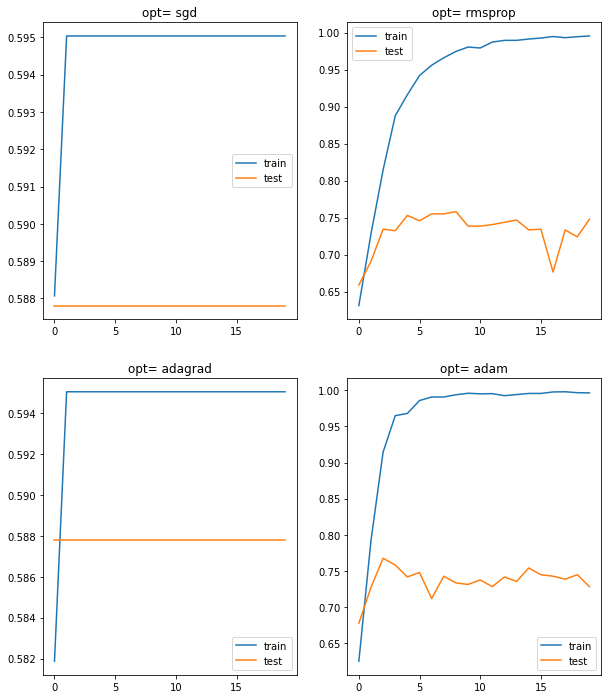

In [228]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adam']
#loss=['categorical_crossentropy','binary_crossentropy']
plt.figure(figsize=(10,12))
for i in range(len(optimizers)):
    # determine the plot number
    plot_no = 220 + (i+1)
    plt.subplot(plot_no)
    # fit model and plot learning curves for an optimizer
    fit_model(optimizers[i])
# show learning curves
plt.show()

We can see from above that the neural network train with optimizer "rmsprop" gives us the best result. The accuracy of the testing set is around 75%. Retrain the model with optimizer "rmsprop". Increase the epoch to 40, to see if it will further increase the accuracy.

In [53]:
model_rmsprop = Sequential()
model_rmsprop.add(Embedding(len(word_index)+1,100,input_length=max_sentence_length-1))
model_rmsprop.add(LSTM(70,dropout=0.1))
model_rmsprop.add(Dense(3, activation='softmax'))
model_rmsprop.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_rmsprop.summary()

model_rmsprop.fit(x_train,y_train, validation_data=(x_test, y_test),batch_size=32, epochs=40, verbose=0)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 100)           1012300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                47880     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 213       
Total params: 1,060,393
Trainable params: 1,060,393
Non-trainable params: 0
_________________________________________________________________


In [61]:
print ("Accuracy of the Training Set")
print (model_rmsprop.evaluate(x_train, y_train)[1]*100, "%")
print ("...................................")
print ("Accuracy of the Testing Set")
print (model_rmsprop.evaluate(x_test,y_test)[1]*100,"%")

Accuracy of the Training Set
121/121 [==============================] - 2s 16ms/step - loss: 0.0012 - accuracy: 0.9995
99.94834661483765 %
...................................
Accuracy of the Testing Set
31/31 [==============================] - 0s 13ms/step - loss: 2.0091 - accuracy: 0.7262
72.62396812438965 %


**The neural network model achieves accuracy of 99% on the training set, and 73% on the testing set.**

The accuracy of the testing is recorded, and compared against that of traditional machine learning algorithm.

In [73]:
y_hat_nn=model_rmsprop.predict(x_test)
y_hat_nn = (y_hat_nn > 0.5)
acc_nn=accuracy_score(y_test,y_hat_nn)
print (acc_nn)

0.7262396694214877


In [304]:
acc_com={"Model":["SVM",'KNeighbours','Logistic Regression','Multinomial Naive Bayes','Neural Network'],"Accuracy":[acc_svm,acc_kn,acc_lr,acc_nb,acc_nn]}
df_acc=pd.DataFrame(acc_com)
df_acc['Accuracy']=df_acc['Accuracy']*100
df_acc

,Model,Accuracy
0,SVM,59.297521
1,KNeighbours,55.578512
2,Logistic Regression,58.264463
3,Multinomial Naive Bayes,46.074380
4,Neural Network,73.243802


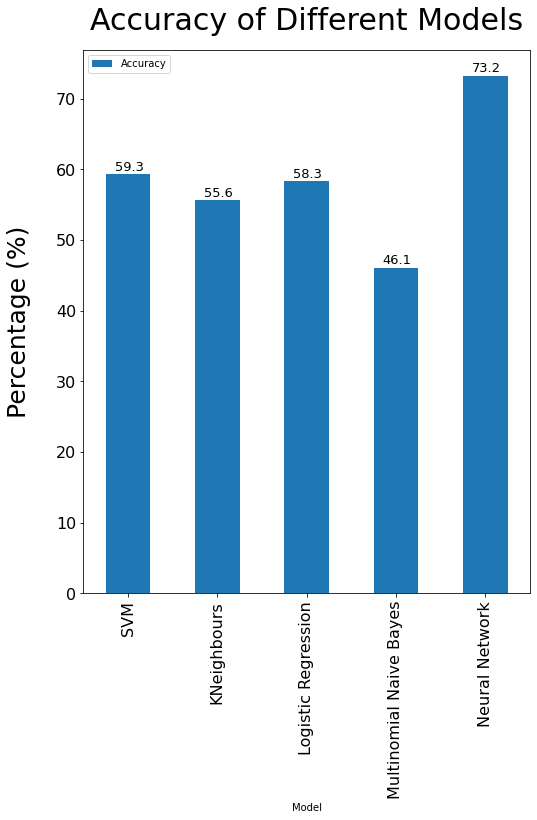

In [336]:
#Visualize the accuracy of different model

ax=df_acc.plot(kind='bar',x='Model',figsize=(8,10))
ax.set_title('Accuracy of Different Models',fontsize=30,pad=20)
ax.legend(loc='upper left')
ax.set_ylabel('Percentage (%)',fontsize=25,labelpad=25)
ax.tick_params(axis='x', labelsize=16,rotation=90)
plt.tick_params(axis='y', labelsize=16)

def add_value_labels(ax, spacing=5):
    
        for rect in ax.patches:
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2
        
             
            label = "{:.1f}".format(y_value)

            ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            textcoords="offset points", # Interpret `xytext` as offset in points
            xytext=(1,1),
            ha='center',                # Horizontally center label
            va='bottom',fontsize=13)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above. All the magic happens there.
add_value_labels(ax)


As shown above, neural network model gives the best accuracy among all the models. 

## Model Testing<a id='tes'></a>

Recall that sentiment category is as below:

0: Negative Sentiment

1: Neutral Sentiment 

2: Positive Sentiment

In [64]:
#define the function to classify sentiment from the model
labels = ['0','1','2']
def get_sentiment(x):
    x=int(x)
    if x==0:
        return "Negative Sentiment"
    elif x==1:
        return " Neutral Sentiment"
    elif x==2:
        return "Positive Sentiment"

We will test the neural network model built above, with new and different data. 

#### Test 1

In [387]:
message=["World’s Biggest Credit ETF Has Just Lost the Most Cash On Record"]
seq = tokenizer1.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=70)

In [388]:
y_hat=model_rmsprop.predict(padded)
pred=labels[np.argmax(y_hat)]
print(y_hat, pred)
print(get_sentiment(pred))

[[0.8307503  0.10701443 0.06223527]] 0
Negative Sentiment


#### Test 2

In [397]:
message=['Xi Says Economy Can Double as China Lays Out Ambitious Plans']
seq = tokenizer1.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=70)

In [398]:
y_hat=model_rmsprop.predict(padded)
pred=labels[np.argmax(y_hat)]
print(y_hat, pred)
print(get_sentiment(pred))

[[2.5832761e-04 7.5684416e-01 2.4289753e-01]] 1
 Neutral Sentiment


#### Test 3

In [393]:
message=['Stocks Surge and Dollar Drops on U.S. Election Day: Markets Wrap']
seq = tokenizer1.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=70)

In [394]:
y_hat=model_rmsprop.predict(padded)
pred=labels[np.argmax(y_hat)]
print(y_hat, pred)
print(get_sentiment(pred))

[[0.6484239  0.34625676 0.00531938]] 0
Negative Sentiment


#### Test 4

In [395]:
message=['Top India Drugmaker Profit Rebounds as Virus Impact Eases']
seq = tokenizer1.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=70)

In [396]:
y_hat=model_rmsprop.predict(padded)
pred=labels[np.argmax(y_hat)]
print(y_hat, pred)
print(get_sentiment(pred))

[[0.00561744 0.96312577 0.03125668]] 1
 Neutral Sentiment


#### Test 5

In [403]:
message=['66% of companies still plan to give bonuses next year']
seq = tokenizer1.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=70)

In [404]:
y_hat=model_rmsprop.predict(padded)
pred=labels[np.argmax(y_hat)]
print(y_hat, pred)
print(get_sentiment(pred))

[[0.00559493 0.9906075  0.00379756]] 1
 Neutral Sentiment


As illustrated from the tests above, the model is able to classify most of the sentiments correctly. 

**Confusion Matrix**

A confusion matrix is plottted below to visualize the performance of the model.

In [102]:
#define the function to plot the confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 80  40  10]
 [ 19 479  71]
 [ 18 107 144]]


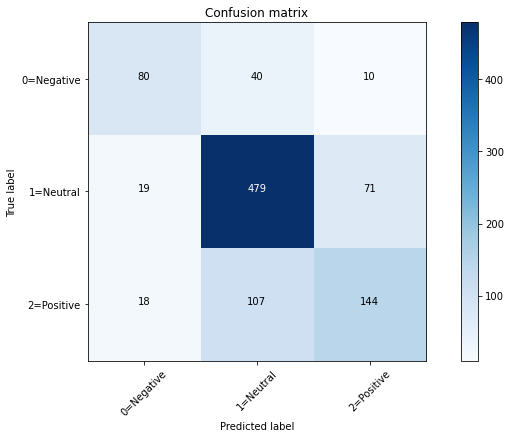

In [103]:
y_hat_nn=model_rmsprop.predict(x_test)
y_hat_nn=np.argmax(y_hat_nn,axis=1)
y_test_nn=np.argmax(y_test,axis=1)
plot_confusion_matrix(cm_nn,classes=['0=Negative','1=Neutral','2=Positive'],normalize=False)

# **Limitation** <a id='lim'></a>

1. The model is built with relatively low amount of data. The model could be further improved by training with more data. 
2. The neural network model is built with relatively simple topology, due to limited resources. There are opportunities for model improvement (such as hyperparameter tuning).
3. Sentiment is subjective and might be perceived differently. The model should perform better if it's used in the same context as the training data (e.g similar audience)

# **Conclusion** <a id='conclusion'></a>

1. The open source data from Kraggle is used to build sentiment classifier model. 

2. Different type of models are built, from traditional machine learning algorithm and neural networks.  In this project, the neural network model gives better accuracy in classfying sentiment of untrained data. 

3. There are some limitation in this project, which are listed in the section [limitation](#lim). These are the opportunities for further improvement. 



# **Reference** <a id='ref'></a>

[1] Siti Khotijah (2020). NLP : Financial News Sentiment Analysis.
https://www.kaggle.com/khotijahs1/nlp-financial-news-sentiment-analysis

[2]Shivam Burnwal (2020). Text Classification Financial News. https://www.kaggle.com/shivamburnwal/text-classification-financial-news